In [1]:
import geomstats
import geomstats.backend as gs
from geomstats.geometry.spd_matrices import *
from geomstats.geometry.stiefel import Stiefel
from geomstats.datasets.utils import load_connectomes
from geomstats.visualization.spd_matrices import Ellipses
from shape_vis import *
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as npla

INFO: Using numpy backend


# Learning distributions of healthy & schizophrenic brain shapes via denoising diffusion on manifolds
## Authors: Marianne Arriola and Ryan Stofer

According to the WHO, Schizophrenia is classified as a mental disorder which impairs a person's ability to think, feel and behave properly. Schizophrenia currently affects approximately 24 million people or 1 in 300 people (0.32%) worldwide and those who are infected with the disease are 2 to 3 times more likely to die early than the general population [1].

In 2014, the IEEE International Workshop on Machine Learning for Signal Processing created a classification challenge open to the public in an effort to promote model building for diagonising schizophrenia from a patient's brain magnetic resonance imaging (MRI) scan [2]. In this notebook, we plan on advancing their work on identifying schizophrenia by utilizing their Functional Network Connectivity (FNC) data taken from a functional magnetic resonance imaging (fMRI) of both schizophrenic and healthy patients to learn distributions of healthy and schizophrenic brain shapes via denoising diffusion on manifolds.

# Marianne: Feel free to edit section above and also maybe talk about implications about how distributions will help people understand schizophrenia more and maybe also more elaborately explain how we will learn and compare the distributions? 

# Loading data

We begin by first loading in our data:

In [21]:
data, ids, target = load_connectomes()
print(data.shape)
print(ids)
print(target)

(86, 28, 28)
[120873 135376 139149 146791 153870 167403 179564 179614 180172 191161
 197297 199397 216806 222333 224755 244353 259678 267327 273218 273762
 275939 277945 290112 293046 295807 298608 323839 337260 348851 403692
 404156 427131 427246 438939 441598 459624 467185 468228 468930 469535
 472665 474861 479741 495307 508321 522766 529803 537342 542571 558698
 559296 570576 573811 581828 582211 597203 609291 617191 641748 702920
 712549 737494 752943 767901 774591 775909 794470 797181 806111 818142
 823981 829335 835522 862050 867297 879556 906283 907482 909442 932646
 933065 934330 950671 963924 993348 993946]
[1 0 0 0 1 0 1 1 1 0 1 0 1 1 1 1 1 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 1 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 1
 0 0 0 1 1 1 0 0 0 1 0 1]


### Manifold of connectomes

Using the `.belongs()` method from the `geomstats` package, we are able to see which manifold our data belongs to. In the following code chunk, we see that each $28 \times 28$ matrix belongs to the Symmetric Positive Definite (SPD) manifold and not the Stiefel manifold.

In [22]:
# show that connectomes belong to manifold of spd matrices
spd = SPDMatrices(28)
spd_affine = SPDBuresWassersteinMetric(28)
stiefel = Stiefel(28,1)
print('Does it belong to SPD?',spd.belongs(data),'\n','Does it belong to Stiefel?',stiefel.belongs(data))

Does it belong to SPD? [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True] 
 Does it belong to Stiefel? [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False Fal

### Processing samples

We now process our samples by creating example graph objects??? of two of our SPD matrices.

In [4]:
# Marianne: Maybe move this somewhere else?
adj_schiz, adj_norm = np.ceil(data[:2])
g_schiz = nx.from_numpy_array(adj_schiz)
g_norm = nx.from_numpy_array(adj_norm)

Furthermore, we introduce two metrics, Affine Invariant Riemannian metric and Log-Euclidean, which are two common metrics that are used when computing with SPD data.

In [5]:
# If you want to implement more metrics, go ahead and use these 
# (Prof Miolane said it would be a good idea to include some more)
ai_metric = SPDAffineMetric(28)
le_metric = SPDLogEuclideanMetric(28)

We also split our data based on whether the patient has schizophrenia or is a part of the healthy control group. Furthermore, we project our data onto the SPD manifold by using the `.projection()` method.

In [6]:
bool_list = list(map(bool,target))
schiz = data[bool_list]
print(schiz.shape)
schiz_spd = spd.projection(schiz)

(40, 28, 28)


In [7]:
flip_bool_list = [not elem for elem in bool_list]
healthy = data[flip_bool_list]
print(healthy.shape)
healthy_spd = spd.projection(healthy)

(46, 28, 28)


## Nina said to maybe also add different metrics and show their distributions as well?

We now compute the Bures-Wasserstein squared distance between each combination of a healthy and schizophrenic patient and plot out its distribution. We notice that there is a noticeable bell-like curve with the values centered around 4.

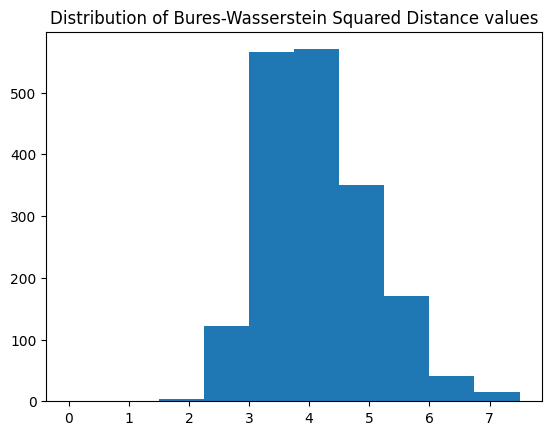

In [8]:
sqrd_dist = compute_sqr_dist(healthy_spd, schiz_spd, 28)

plt.hist(sqrd_dist,range=(0,np.max(sqrd_dist)))
plt.title('Distribution of Bures-Wasserstein Squared Distance values')
plt.show()

We plot out an example SPD matrix of both a healthy and schizophrenic brain's FNC correlation matrix.

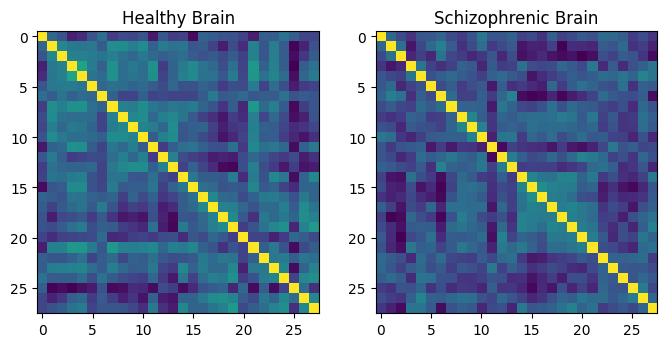

In [25]:
labels_str = ["Healthy Brain", "Schizophrenic Brain"]

fig = plt.figure(figsize=(8, 4))
plot_SPD_image(data[0], 122, labels_str[target[0]])
plot_SPD_image(data[1], 121, labels_str[target[1]])
plt.show()

We now plot out the average FNC correlation matrices for both a healthy brain and a schizophrenic brain.

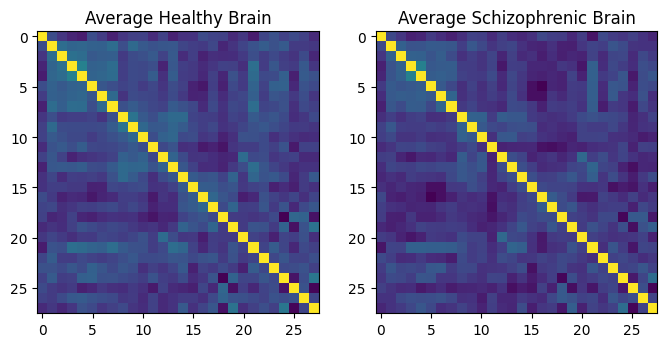

In [24]:
ave_schiz = np.sum(schiz_spd, axis = 0)/len(schiz[0])
ave_healthy = np.sum(healthy_spd, axis = 0)/len(healthy[0])

fig = plt.figure(figsize=(8, 4))
plot_SPD_image(ave_healthy, 121, 'Average Healthy Brain')
plot_SPD_image(ave_schiz, 122, 'Average Schizophrenic Brain')
plt.show()

We now compute the Riemannian logarithm based on the schizophrenic SPD matrix with respect to the Bures-Wasserstein metric. This produces a tangent vector at the schizophrenic SPD matrix. We then plot out 4 random images of the (1480) log vectors for visualization.

In [9]:
log_vec = compute_log(healthy_spd, schiz_spd, 28)

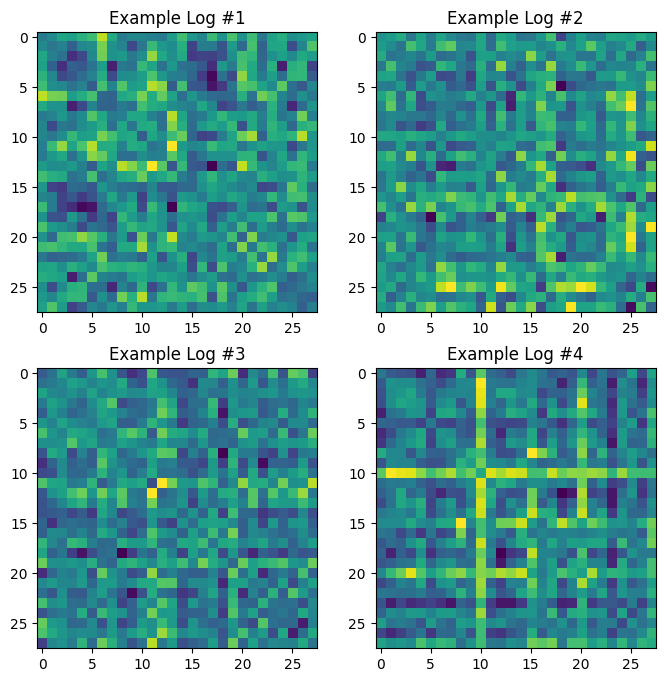

In [10]:
random_vecs = np.random.randint(log_vec.shape[0], size=4)
plt.figure(figsize=(8,8))
plot_SPD_image(log_vec[random_vecs[0]], 221, 'Example Log #1')
plot_SPD_image(log_vec[random_vecs[1]], 222, 'Example Log #2')
plot_SPD_image(log_vec[random_vecs[2]], 223, 'Example Log #3')
plot_SPD_image(log_vec[random_vecs[3]], 224, 'Example Log #4')
plt.show()

### Spatial comparison

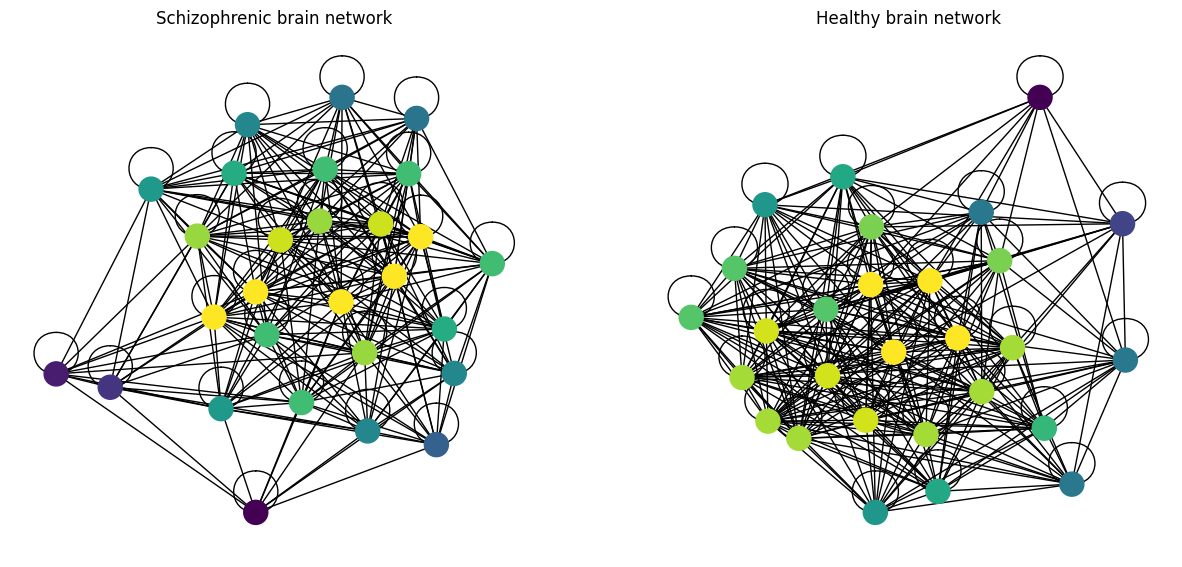

In [13]:
plt.figure(figsize=(15,15))
plot_graphs_spatial(g_schiz,221,"Schizophrenic brain network")
plot_graphs_spatial(g_norm,222,"Healthy brain network")
plt.show()

### Spectral comparison

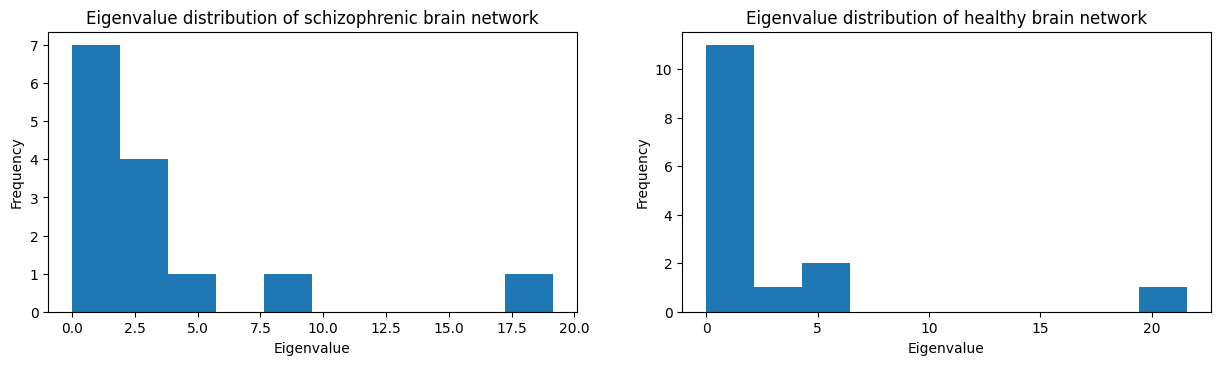

In [14]:
plt.figure(figsize=(15,8))
plot_graphs_spectral(g_schiz,221,"Eigenvalue distribution of schizophrenic brain network")
plot_graphs_spectral(g_norm,222,"Eigenvalue distribution of healthy brain network")
plt.show()

NOTE: The eigenvalues of the schizophrenic brain network are skewed to higher values. This aligns with the finding in [] that anomalous networks are associated with higher spectral energy.

References: # MARIANNE IDK HOW TO CITE THIS CORRECTLY HELP!!!

[1] https://www.who.int/news-room/fact-sheets/detail/schizophrenia

[2] https://www.kaggle.com/competitions/mlsp-2014-mri/overview